## CLM-PPE LAI test with
#### Updated April 17, 2023

- Evaluate our approach to emulation
  - Variable: Annual max LAI averaged by biome (1982-2010)
  - Error: (model-obs)2/stdev(obs)  sumed over biomes
  - Observational target: AVHRR annual max LAI (1982-2010)

- Total error emulator (1)
  - Calculate total error (sum of error over biomes)
  - Train one emulator to predict total error

- Biome specific emulators (9)
  - Train individual emulators for each biome to predict the biome mean annual maximum LAI
  - Use emulated biome LAI to calculate total error


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from esem import gp_model
from esem.utils import get_random_params, leave_one_out, prediction_within_ci
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import gpflow

2023-04-18 09:10:29.933719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 09:10:30.441534: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 09:10:30.765601: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-18 09:10:33.468603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [1]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") ; sys.path.append("../pyth/")
from ppe_analysis.analysis import *
from pyfunctions import *
from emulation_pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [5]:
client.cluster

PBSCluster(ccc0d36f, 'tcp://10.12.206.57:37530', workers=20, threads=20, memory=186.20 GiB)

### Load CLM-PPE

In [6]:
# load LHC LAI
ds_h0=get_exp('transient',dvs=['TLAI','GPP'],yy=(1982,2010))

t=slice(str(1982),str(2010))
ds1982 = ds_h0.sel(time=t)

In [7]:
BM_LHC = bmean(amax(ds1982.TLAI).mean(dim='year'),ds1982.la).compute()

In [8]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

### Load Observational data

In [9]:
# Load AVHRR 
ds_AVHRR =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/AVHRR_LAI_regridded.nc')
jvals, ivals = get_sparsegrid()
la = get_la()

AVHRR = bmean(amax(ds_AVHRR.AVHRR_LAI[:,jvals,ivals]),la).compute()

In [10]:
# load regridded ILAMB datasets (MODIS, AVHRR, AVH15C1)
ds_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_LAI_regridded.nc')

# Calculate ILAMB biome LAI
BM_MODIS = bmean(amax(ds_ilamb.MODIS_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
BM_AVHRR = bmean(amax(ds_ilamb.AVHRR_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
BM_AVH15C1 = bmean(amax(ds_ilamb.AVH15C1_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()

# observational data for error threshold
BM_obs = [BM_MODIS, BM_AVHRR, BM_AVH15C1]

### Biome Specfic Emulators

In [11]:
# define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))

kernel = kernel_linear + kernel_matern32

2023-04-18 09:18:00.345736: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-18 09:18:00.345816: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc56): /proc/driver/nvidia/version does not exist
2023-04-18 09:18:00.387671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


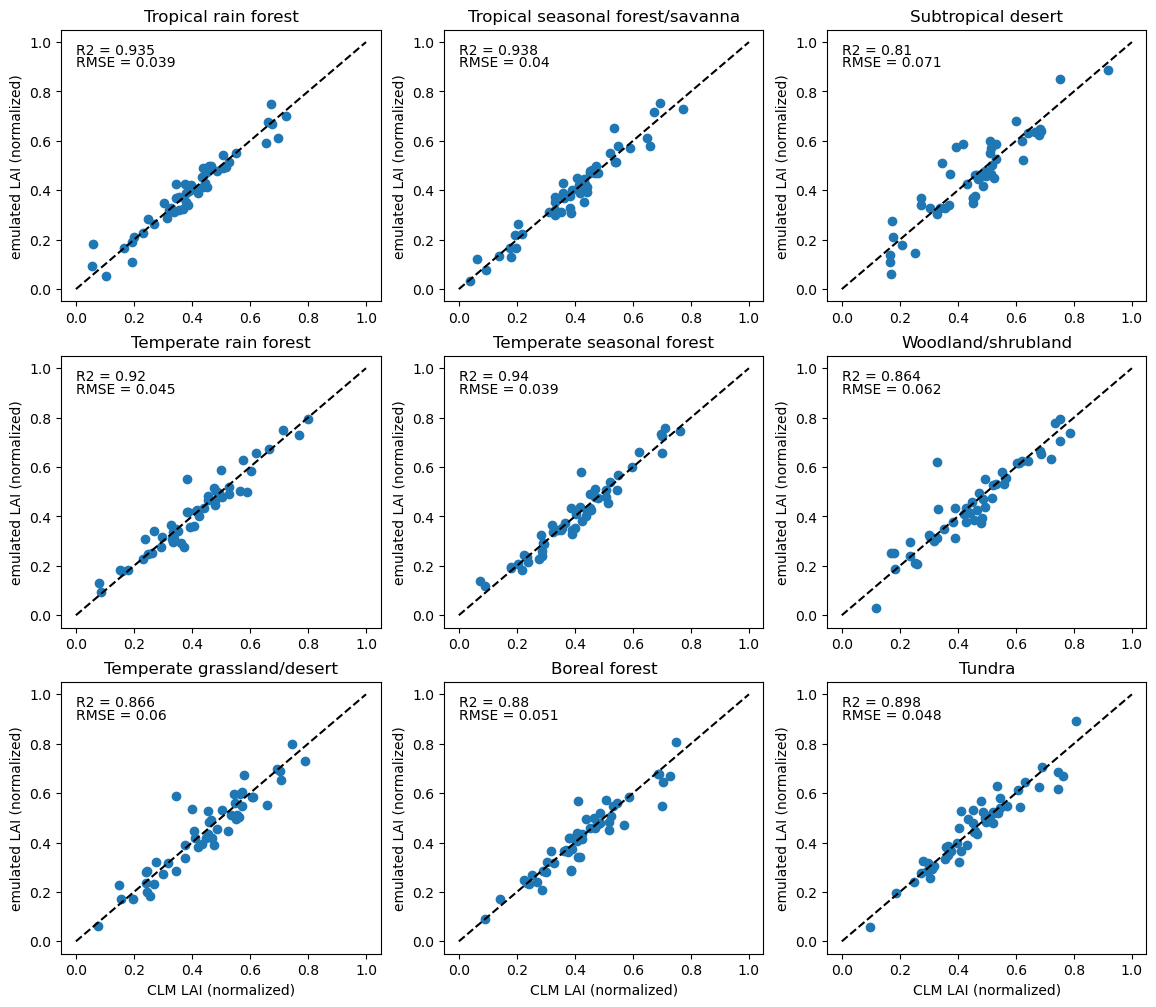

In [12]:
plt.figure(figsize=[14,12])
plt.rcParams.update({'font.size': 10})

emulator_dict = {}

for b in range(1,10):
    var = normalize(BM_LHC.sel(biome=b))
    n_test = 50 # number of ensemble members to test emulator
    Y = var[1:].values # target variable excluding default model [0]

    X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
    y_test, y_train = Y[:n_test], Y[n_test:]

    # define emulator model and train
    emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
    emulator.train()

    emulator_dict[b] = emulator
    
    # Predict test points with emulator and plot
    y_pred, y_pred_var = emulator.predict(X_test.values)

    rms = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test,y_pred)

    ax = plt.subplot(3,3,b)
    ax.scatter(y_test,y_pred)
    ax.text(0,0.95,'R2 = '+str(np.round(r2,3)),fontsize=10)
    ax.text(0,0.90,'RMSE = '+str(np.round(rms,3)),fontsize=10)
    ax.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
    if b > 6:
        ax.set_xlabel('CLM LAI (normalized)')
    ax.set_ylabel('emulated LAI (normalized)')
    ax.set_title(BM_LHC['biome_name'][b].values)

plt.savefig('./figs/Biome_emulator_validation.png',dpi = 100)

In [13]:
# sample parameter space 
np.random.seed(444)
r1_sample = get_random_params(len(X_train.columns), 10000)
sample_ids = np.arange(len(r1_sample))

In [14]:
## Ask each biome emulator to predict r1 samples 
BM_pred = np.empty([10,len(r1_sample)])

for b in range(1,10):
    y_pred, _ = emulator_dict[b].predict(r1_sample) #emulator predicted normalize biome mean max LAI
    BM_pred[b] = unnormalize(y_pred,BM_LHC.sel(biome=b))

In [15]:
# Calculate error metric
# Biome sum( error2 / stdev (AVHRR))
BM_pred_e2sd = [cal_e2sd(BM_pred[1:,i],AVHRR[1:]) for i in range(np.shape(BM_pred)[1])]
BM_pred_e2sd = np.array(BM_pred_e2sd)

In [16]:
#Check total error score 
X_test = ppe_params[:n_test]
y_pred_org = np.empty([10,n_test])

for b in range(1,10):
    y_pred, _ = emulator_dict[b].predict(X_test) 
    y_pred_org[b] = unnormalize(y_pred,BM_LHC.sel(biome=b))
    
y_pred_e2sd = [cal_e2sd(y_pred_org[1:,i],AVHRR[1:]) for i in range(n_test)]
y_lhc_e2sd = [cal_e2sd(BM_LHC[1:,i],AVHRR[1:]) for i in range(1,n_test+1)]

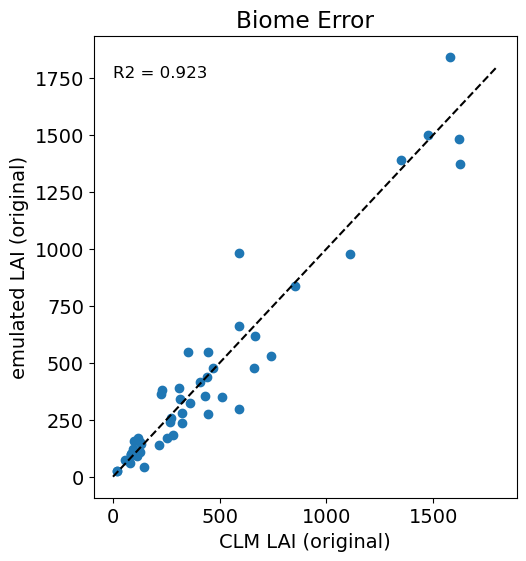

In [17]:
plt.figure(figsize=[12,6])
plt.rcParams.update({'font.size': 14})

ax = plt.subplot(1,2,2) 
ax.scatter(y_lhc_e2sd,y_pred_e2sd)
r2 = r2_score(y_lhc_e2sd,y_pred_e2sd)
ax.text(0,1750,'R2 = '+str(np.round(r2,3)),fontsize=12)
ax.plot([0,1800],[0,1800],c='k',linestyle='--',label='1:1 line')
ax.set_title('Biome Error')
ax.set_xlabel('CLM LAI (original)')
ax.set_ylabel('emulated LAI (original)')

plt.savefig('./figs/val_LHC_e2sd_BiomeError.png',dpi=200)

### Total Error

In [18]:
LHC_e2sd = [cal_e2sd(BM_LHC[1:,i],AVHRR[1:]) for i in range(np.shape(BM_LHC)[1])]

In [19]:
## train emulators
# define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))

kernel = kernel_linear + kernel_matern32

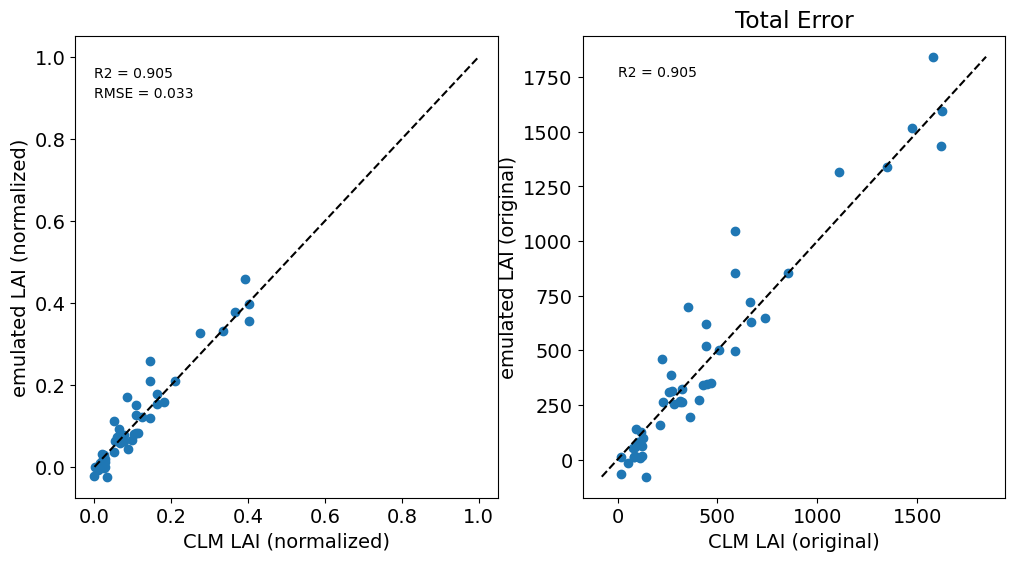

In [20]:
# train emulator
in_var = np.array(LHC_e2sd)
var = normalize(in_var)
n_test = 50 # number of ensemble members to test emulator
Y = var[1:]#.values # target variable excluding default model [0]

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

# define emulator model and train
E2SDemulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
E2SDemulator.train()

# Predict test points with emulator and plot
y_pred, y_pred_var = E2SDemulator.predict(X_test.values)

plt.figure(figsize=[12,6])
plt.rcParams.update({'font.size': 14})

ax = plt.subplot(1,2,1)
ax.scatter(y_test,y_pred)
rms = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test,y_pred)
ax.text(0,0.95,'R2 = '+str(np.round(r2,3)),fontsize=10)
ax.text(0,0.90,'RMSE = '+str(np.round(rms,3)),fontsize=10)
ax.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
ax.set_xlabel('CLM LAI (normalized)')
ax.set_ylabel('emulated LAI (normalized)')

ax= plt.subplot(1,2,2)
Xvar = unnormalize(y_test,in_var)
Yvar = unnormalize(y_pred,in_var)
ax.scatter(Xvar,Yvar)
rms = mean_squared_error(Xvar, Yvar, squared=False)
r2 = r2_score(Xvar,Yvar)
ax.text(0,0.95*max(Yvar),'R2 = '+str(np.round(r2,3)),fontsize=10)
#ax.text(0,0.90*max(Yvar),'RMSE = '+str(np.round(rms,3)),fontsize=10)
ax.plot([min(Yvar),max(Yvar)],[min(Yvar),max(Yvar)],c='k',linestyle='--',label='1:1 line')
ax.set_xlabel('CLM LAI (original)')
ax.set_ylabel('emulated LAI (original)')
ax.set_title('Total Error')

plt.savefig('./figs/val_LHC_e2sd_TotalError.png',dpi=200)

In [21]:
pred_e2sd, _ = E2SDemulator.predict(r1_sample) 
TE_pred_e2sd = unnormalize(pred_e2sd,LHC_e2sd)

### Select sets within observational tolerance

In [22]:
#define observational error
BM_obs_e2sd = [cal_e2sd(BM_obs[i][1:],AVHRR[1:]) for i in range(len(BM_obs))]

# interannual range in error
e2sd_iav_error=[cal_e2sd(AVHRR[1:,i],AVHRR) for i in range(np.shape(AVHRR)[1])]

# set observational tolerance
e2sd_obs_range = max(BM_obs_e2sd)+max(e2sd_iav_error)

# Identify parameter sets in r1_sample that are within tolerance
BM_sets_e2sd = np.argwhere(BM_pred_e2sd<e2sd_obs_range.values)
TE_sets_e2sd = np.argwhere((TE_pred_e2sd>0) & (TE_pred_e2sd<e2sd_obs_range.values))


In [23]:
ix = np.isin(TE_sets_e2sd,BM_sets_e2sd)
common_sets = TE_sets_e2sd[ix]

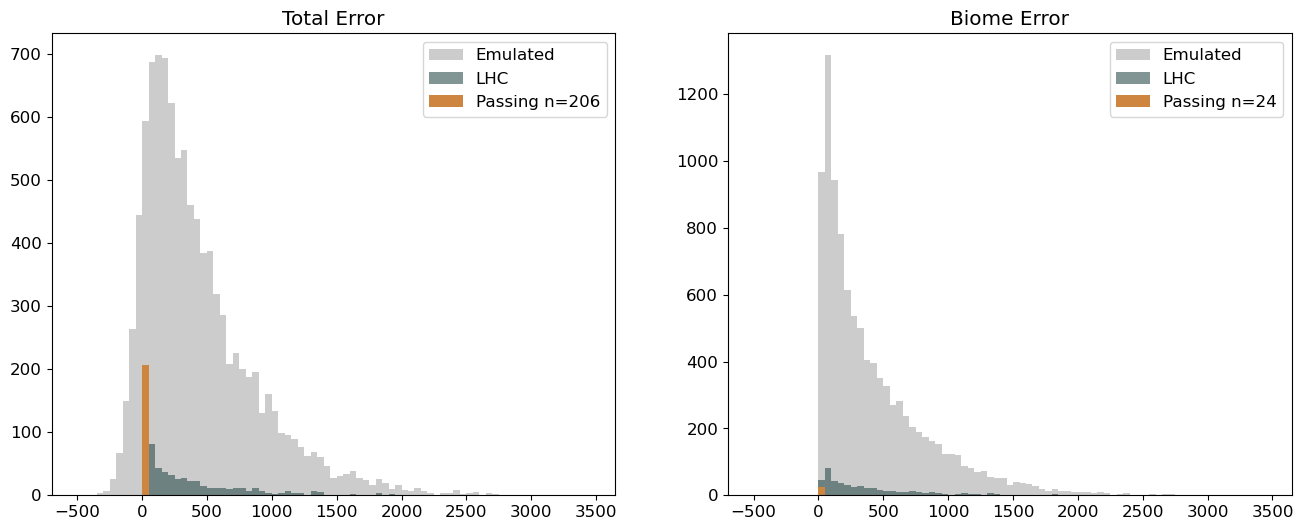

In [24]:
plt.figure(figsize=[16,6])
plt.rcParams.update({'font.size': 12})

plt.subplot(1,2,1)
bins = np.arange(-500,3500,50) 
plt.hist(TE_pred_e2sd,bins=bins,color='grey',alpha=0.4,label = 'Emulated')
plt.hist(LHC_e2sd,bins=bins,color='darkslategrey',alpha=0.6, label='LHC')
plt.hist(TE_pred_e2sd[TE_sets_e2sd],bins=bins,color='peru',label='Passing n='+str(len(TE_sets_e2sd)))
plt.title('Total Error')
plt.legend()

plt.subplot(1,2,2)
plt.hist(BM_pred_e2sd,bins=bins,color='grey',alpha=0.4,label='Emulated')
plt.hist(LHC_e2sd,bins=bins,color='darkslategrey',alpha=0.6, label='LHC')
plt.hist(BM_pred_e2sd[BM_sets_e2sd.flatten()],bins=bins,color='peru',label='Passing n='+str(len(BM_sets_e2sd)))
plt.title('Biome Error')
plt.legend()

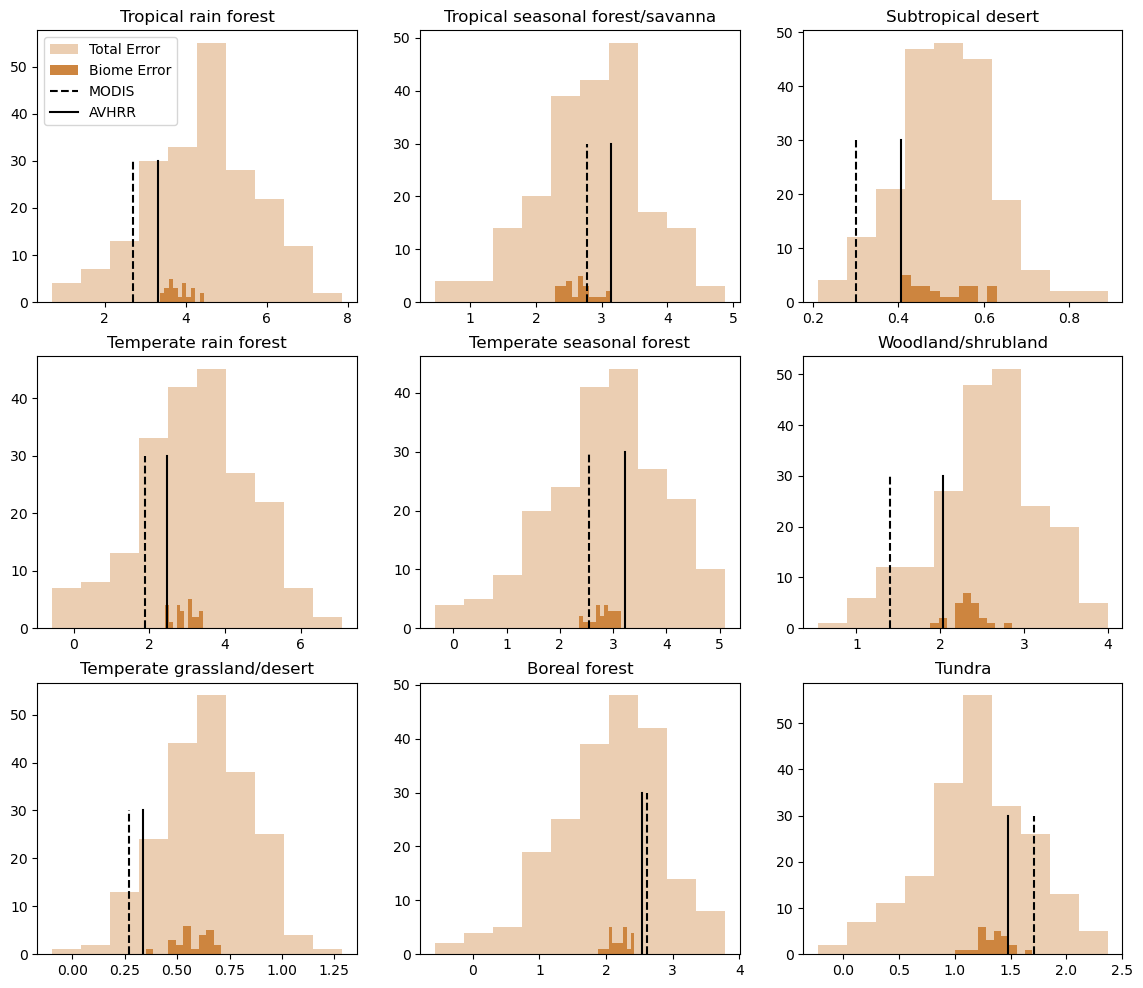

In [25]:
plt.figure(figsize=[14,12])
plt.rcParams.update({'font.size': 10})

v1 = BM_pred[:,BM_sets_e2sd.flatten()]
v3 = BM_pred[:,TE_sets_e2sd]

for b in range(1,10):
    plt.subplot(3,3,b)

    plt.hist(v3[b,:],alpha = 0.4,color='peru',label='Total Error')
    plt.hist(v1[b,:],alpha = 1,color='peru',label='Biome Error')
    
    #plt.plot([BM_sp[b],BM_sp[b]],[0,100],'k--',label='SP')
    plt.plot([BM_MODIS[b],BM_MODIS[b]],[0,30],'k--',label='MODIS')
    plt.plot([BM_AVHRR[b],BM_AVHRR[b]],[0,30],'k-',label='AVHRR')
    
    plt.title(BM_AVHRR['biome_name'][b].values)
    if b ==1:
        plt.legend()
plt.savefig('./figs/Biome_e2sd_AVHRR.png',dpi=300)

### Where are they in Parameter Space? 

In [26]:
BM_psets_e2sd = r1_sample[BM_sets_e2sd.flatten(),:]
TE_psets_e2sd = r1_sample[TE_sets_e2sd.flatten(),:]

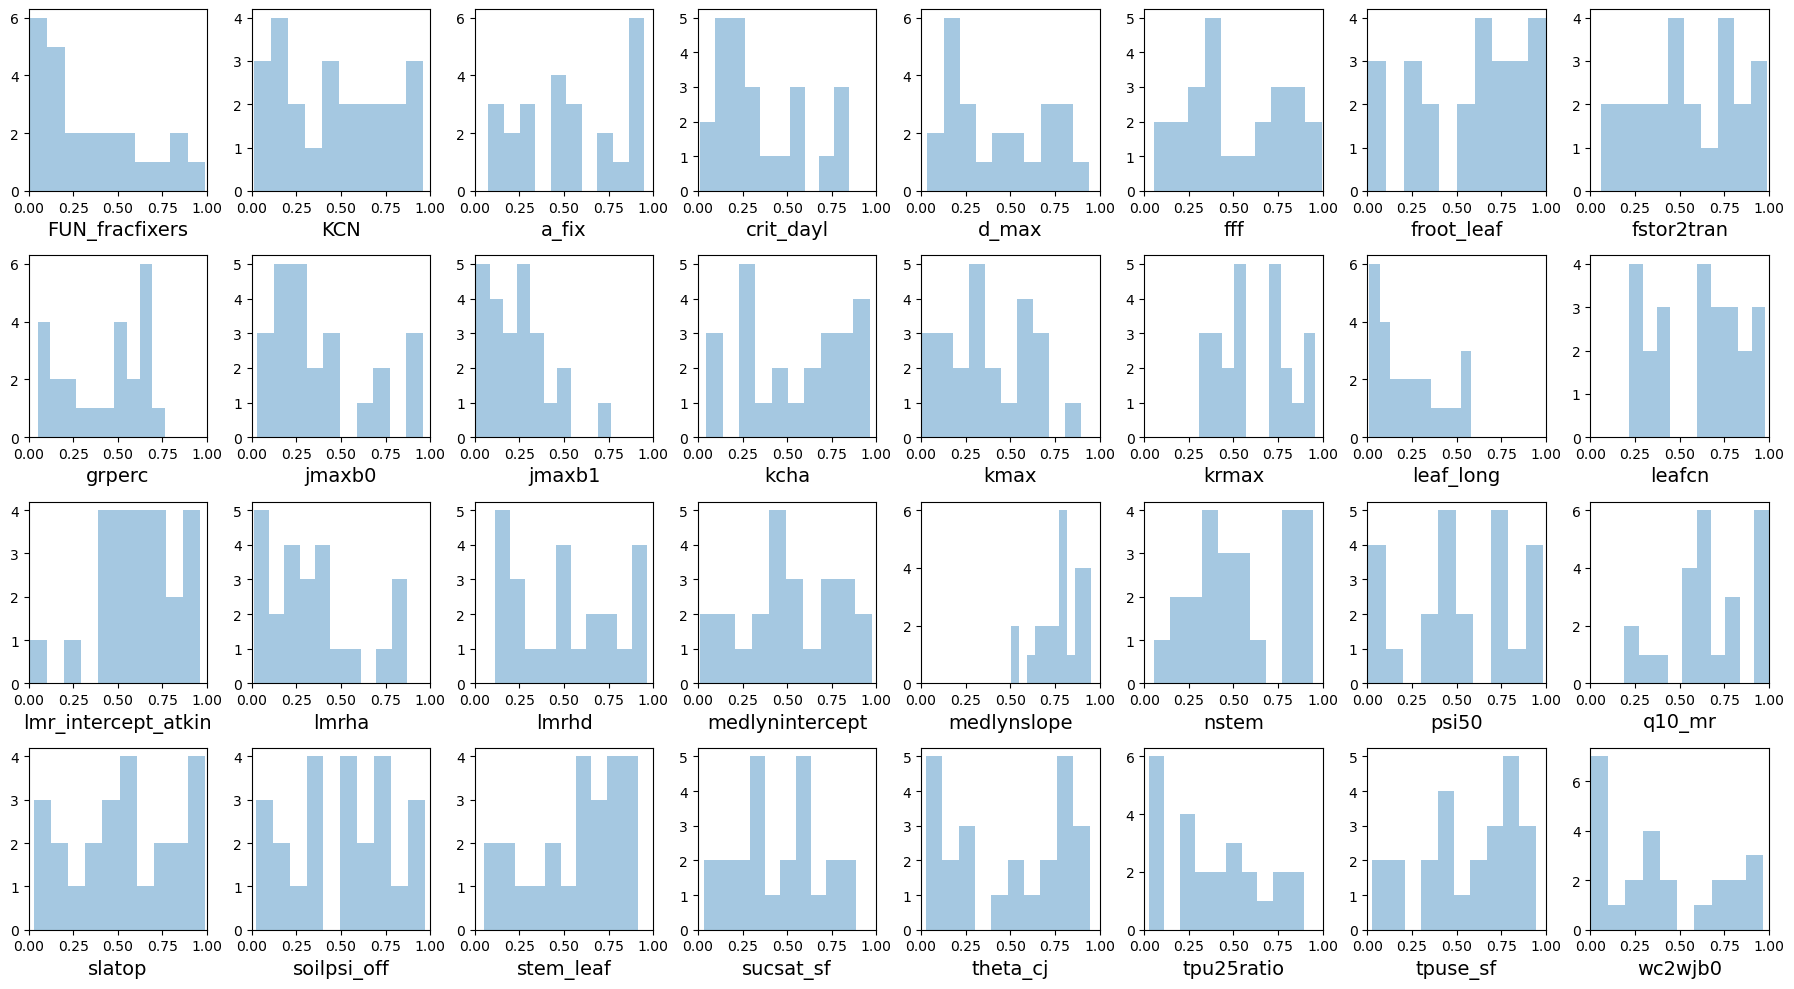

In [27]:
plt.figure(figsize=[18,10])
psets = pd.DataFrame(BM_psets_e2sd,columns=ppe_params.columns)

for p in range(num_params):
    plt.subplot(4,8,p+1)
    pname = ppe_params.columns[p]
    sns.distplot(psets[pname], bins=10, kde = False, label='')
    plt.xlim([0,1])
    plt.ylabel('')
    plt.xlabel(pname,fontsize=14)
    #plt.legend()
plt.tight_layout()
plt.savefig('./figs/pass_BMe2sd.png')

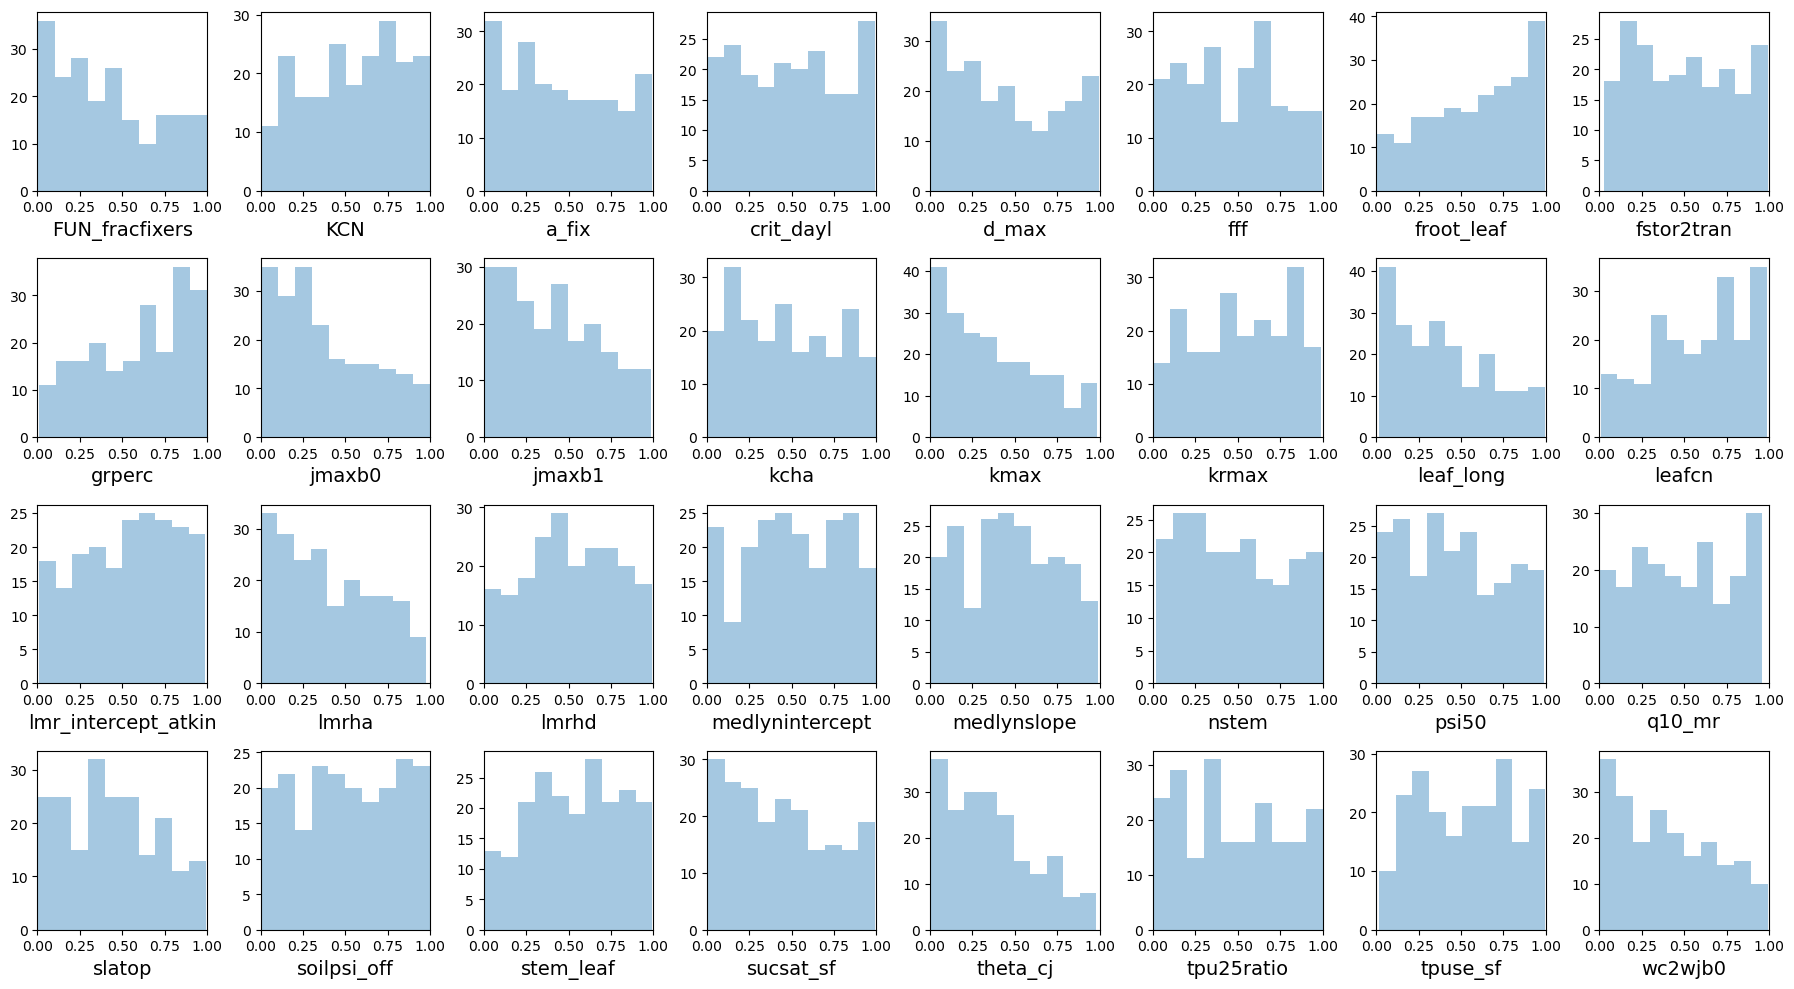

In [28]:
plt.figure(figsize=[18,10])
psets = pd.DataFrame(TE_psets_e2sd,columns=ppe_params.columns)

for p in range(num_params):
    plt.subplot(4,8,p+1)
    pname = ppe_params.columns[p]
    sns.distplot(psets[pname], bins=10, kde = False, label='')
    plt.xlim([0,1])
    plt.ylabel('')
    plt.xlabel(pname,fontsize=14)
    #plt.legend()
plt.tight_layout()
plt.savefig('./figs/pass_TEe2sd.png')

### Select parameter sets

In [180]:
best_set = np.argmin(TE_pred_e2sd[TE_sets_e2sd])
best_set

146

In [167]:
def manhattan_distance(point1, point2):
    return sum(abs(value1 - value2) for value1, value2 in zip(point1, point2))

In [168]:
dist_mat = np.empty((len(TE_psets_e2sd),len(TE_psets_e2sd)))
for i in range(len(TE_psets_e2sd)):
    for j in range(len(TE_psets_e2sd)):
        a = ppe_params.iloc[i]
        b = ppe_params.iloc[j]
        dist_mat[i,j] = manhattan_distance(a,b)

In [169]:
ix = TE_psets_e2sd[:,0] ==r1_sample[common_sets,0]
init = np.argmax(dist_mat[ix,:])
psets = [init]

for i in range(24):
    if i ==0:
        arr1 = dist_mat[init,:]
        val = np.argmax(arr1)
    else:
        arr1 = dist_mat[val,:]
        arr2 = arr1+total
        val = np.argmax(arr2)
    
    psets.append(val)
    total = arr1+dist_mat[val,:]

In [181]:
dist_sets = psets[1:7]
dist_sets

[97, 12, 131, 40, 17, 46]

In [188]:
# add some random sets
np.random.seed(21)
add_sets = np.round(np.random.uniform(low=0, high=len(TE_psets_e2sd), size=17))

In [189]:
TE_sets = add_sets
for i in range(6):
    val = np.int(sets[i])
    TE_sets = np.append(TE_sets,val)
TE_sets = np.append(TE_sets,best_set)
TE_sets = TE_sets.astype(int)

In [190]:
TE_sets

array([ 10,  60, 149,   4,  42,  10,  62, 137,  63, 120,  14, 179,  27,
        37, 102, 178, 156,  97,  12, 131,  40,  17,  46, 146])

### Save parameter sets

In [35]:
BM_df = pd.DataFrame(BM_psets_e2sd,columns=ppe_params.columns)
BM_df.to_csv('exp1_e2sd_BiomeEmulators_psets.csv')
#np.savetxt("exp1_e2sd_BiomeEmulators_psets.csv", BM_psets_e2sd, delimiter = ",")

In [191]:
TE_df = pd.DataFrame(TE_psets_e2sd[TE_sets,:],columns=ppe_params.columns)
TE_df.to_csv('exp1_e2sd_TotalErrorEmulator_psets.csv')

### Save emulators

### Check GPP in selected sets

In [ ]:
# Calculate biome mean
da=ds_h0.GPP
BM_GPP = bmean(amean(da),la).compute()

In [ ]:
# load observations
jvals, ivals = get_sparsegrid()
la = get_la()

ds_gpp_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_GPP_regridded.nc')

FLX_gpp = amean(ds_gpp_ilamb.FLUXCOM_GPP)
wecann_gpp = amean(ds_gpp_ilamb.WECANN_GPP)

biome_FLX = bmean(FLX_gpp[:,jvals,ivals],la)
biome_WECANN = bmean(wecann_gpp[:,jvals,ivals],la)

In [ ]:
BM_lhc_gpp = BM_GPP.mean(dim='year').compute()

In [ ]:
# train emulators
plt.figure(figsize=[14,12])
plt.rcParams.update({'font.size': 10})

gpp_emulator_dict = {}

for b in range(1,10):
    var = normalize(BM_lhc_gpp.sel(biome=b))
    n_test = 50 # number of ensemble members to test emulator
    Y = var[1:].values # target variable excluding default model [0]
    default = var[0].values # default model value

    X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
    y_test, y_train = Y[:n_test], Y[n_test:]

    # define emulator model and train
    emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
    emulator.train()

    gpp_emulator_dict[b] = emulator
    
    # Predict test points with emulator and plot
    y_pred, y_pred_var = emulator.predict(X_test.values)

    rms = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test,y_pred)

    ax = plt.subplot(3,3,b)
    ax.scatter(y_test,y_pred)
    ax.text(0,0.95,'R2 = '+str(np.round(r2,3)),fontsize=10)
    ax.text(0,0.90,'RMSE = '+str(np.round(rms,3)),fontsize=10)
    ax.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
    if b > 6:
        ax.set_xlabel('CLM GPP (normalized)')
    ax.set_ylabel('emulated GPP (normalized)')
    ax.set_title(BM_lhc_gpp['biome_name'][b].values)

plt.savefig('./figs/Biome_emulator_validation_GPP.png',dpi = 100)

In [ ]:
# predict r1 sample
## Ask each emulator to predict r1 samples 
BM_GPP_pred = np.empty([10,len(r1_sample)])

for b in range(1,10):
    y_pred, _ = emulator_dict[b].predict(r1_sample) #emulator predicted normalize biome mean max LAI
    BM_GPP_pred[b] = unnormalize(y_pred,BM_lhc_gpp.sel(biome=b))

In [ ]:
# calculate error
# mape
BM_pred_gpp = [cal_mape(BM_GPP_pred[1:,i],biome_FLX[1:].mean(dim='year')) for i in range(np.shape(BM_GPP_pred)[1])]
BM_pred_gpp = np.array(BM_pred_gpp)

In [ ]:
# error2/stdev (e2sd)
#BM_pred_gpp = [cal_e2sd(BM_GPP_pred[1:,i],biome_FLX[1:]) for i in range(np.shape(BM_GPP_pred)[1])]
#BM_pred_gpp = np.array(BM_pred_gpp)

In [ ]:
# scatter plot of LAI/GPP for each subset 
plt.scatter(BM_pred_e2sd,BM_pred_gpp)
plt.scatter(BM_pred_e2sd[BM_sets_e2sd.flatten()],BM_pred_gpp[BM_sets_e2sd.flatten()])